# Generates all plots

### Python imports

In [1]:
import numpy as np
# ===================
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as clr
# ====================
import copy
import glob
import re
import spiceypy

### MATPLOTLIB definitions

In [2]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=14)
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = 7, 0.8*7 # inches, Acta paper width

### Useful function definitions

In [3]:
def _make_gen(reader): # Helper function for efficiently reading large datasets
    b = reader(1024 * 1024)
    while b:
        yield b
        b = reader(1024 * 1024)

def rawgencount(filename):
    f = open(filename, 'rb')
    f_gen = _make_gen(f.raw.read)

    return sum( buf.count(b'\n') for buf in f_gen)

def get_spk_id(str_in):

    m = re.search('threshold_\w+', str_in)
    m = re.search('\_\w+', m.group(0))
    
    if re.search('minus', str_in) is not None:  # Then negative
        
        return "-"+m.group(0)[1:]
    
    return m.group(0)[1:]

### Variable defs

In [4]:
number_of_candidates = []
date_of_study = []
threshold_velocity = []

fname_prefixes = ["threshold/threshold_", "threshold/minus_"]

## Generate candidate threshold plots

### Import data

In [5]:
for directory in fname_prefixes:
    for file in glob.glob(directory+"*"): # basic regex search
        velocity_id = int( get_spk_id(file) )
        date_of_study.append(velocity_id)  # hardcode
        threshold_velocity.append(0.7 + velocity_id * .05)  # 50 m/s increments
        number_of_candidates.append( rawgencount(file) )  # append number of lines (= number of candidates)
        
# Fix offset

offset = np.min(date_of_study)
_tmp = [date+abs(offset) for date in date_of_study]
date_of_study = _tmp

### Sort

In [6]:
permutation_idx = np.argsort(np.array(date_of_study))
threshold_velocity = np.sort(threshold_velocity)
number_of_candidates = np.array(number_of_candidates); number_of_candidates = number_of_candidates[permutation_idx]

### Plot v1

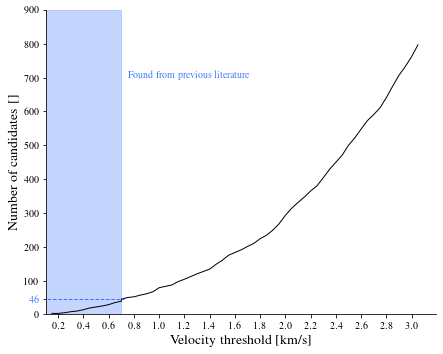

In [7]:
plt.plot(threshold_velocity, number_of_candidates, 'k')
xticks = np.arange(0., np.max(threshold_velocity), 0.2)
plt.xticks(xticks)
plt.yticks(list(plt.yticks()[0]) + [46])

# Labels

plt.xlabel('Velocity threshold [km/s]')
plt.ylabel('Number of candidates []')
plt.xlim(left=0.1)
plt.ylim(bottom=0)

# Shading

plt.axvspan(0., .7, alpha=.3, color='xkcd:lightish blue')  #vertical shading
plt.annotate('Found from previous literature', (.75, 700), color='xkcd:lightish blue')

# Highlight line

plt.axhline(46, xmin=-.05, xmax=.20, linestyle='--', color='xkcd:lightish blue')

plt.gca().get_yticklabels()[-1].set_color("xkcd:lightish blue")

### Plot v2

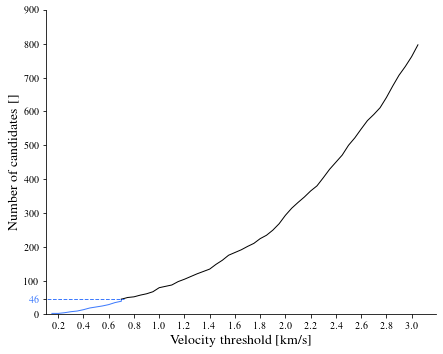

In [8]:
plt.plot(threshold_velocity[0:13], number_of_candidates[0:13], color='xkcd:lightish blue', label='Threshold from previous literature')
plt.plot(threshold_velocity[12:], number_of_candidates[12:], color='k', label='Additional candidates')
xticks = np.arange(0., np.max(threshold_velocity), 0.2)
plt.xticks(xticks)
plt.yticks(list(plt.yticks()[0]) + [46])

# Labels

plt.xlabel('Velocity threshold [km/s]')
plt.ylabel('Number of candidates []')
plt.xlim(left=0.1)
plt.ylim(bottom=0)

# Highlight line

plt.axhline(46, xmin=-.05, xmax=.20, linestyle='--', color='xkcd:lightish blue')

plt.gca().get_yticklabels()[-1].set_color("xkcd:lightish blue")
# plt.legend(loc='upper left')

### Generate prefilter vs time plot

#### Initialise parameters

In [9]:
bodyid = '3410533'
fname = bodyid
spiceypy.furnsh('naif0008.tls')
spiceypy.furnsh('de414.bsp')
spiceypy.furnsh('../ephemeris_files/ephemeris_files/'+bodyid+'.bsp')

#### Load data

In [10]:
data = np.genfromtxt(fname, dtype=float, usecols=(0,1))
orbit_type = np.genfromtxt(fname, dtype='unicode', usecols=(2))
unique, indices = np.unique(orbit_type, return_inverse=True)

#### Compute Jacobi energy

In [11]:
time1 = spiceypy.str2et('Jan 1 2025 00:00')
time2 = spiceypy.str2et('Dec 31 2099 00:00')

times = np.arange(time1, time2, 28 * 86400)

# Get OEs

OEs = np.ndarray((len(times), 8), dtype=float)

for i in range(len(times)):
    time = times[i]
    states = spiceypy.spkezr(bodyid, time, 'ECLIPJ2000', 'None', 'Sun')
    OEs[i,:] = spiceypy.oscelt(states[0], time, 1.32712440018e11)

a = OEs[:,0]/(1-OEs[:,1]) / 1.495978707e8
jacobis = 1/a + 2.0 * np.sqrt(a * (1-OEs[:,1] * np.cos(OEs[:,2])))

#### Plot v1

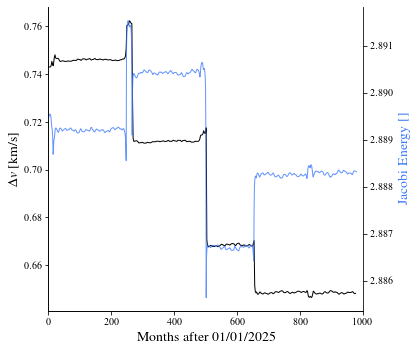

In [12]:
fig = plt.figure()
host = fig.add_subplot(111)
plt.subplots_adjust(right=.75)

par1 = host.twinx()

host.set_xlabel('Months after 01/01/2025')
host.set_ylabel(r'$\Delta v$ [km/s]')

par1.set_ylabel('Jacobi Energy []')

p1,  = host.plot(data[:,0], data[:,1], 'k-', label=r'$\Delta v$ [km/s]')
p2, = par1.plot(jacobis, linestyle='-', color='xkcd:lightish blue', alpha=.8, label='Jacobi Energy')

lns = [p1, p2]

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.gca().spines['right'].set_visible(True)
plt.gca().set_xlim(0, 1000)
plt.show()

#### Plot v2

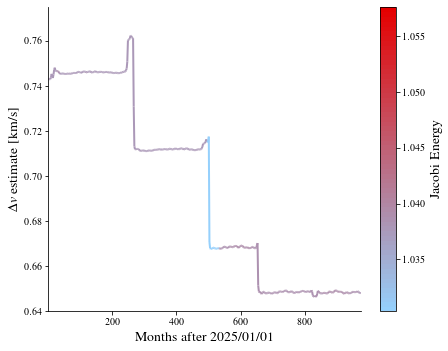

In [13]:
x = data[:,0]
y = data[:,1]
magnitude = a  # first derivative


# Custom colorbar
cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#95d0fc','#e50000'], N=64)

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(magnitude.min(), magnitude.max())
lc = LineCollection(segments, cmap=cmap, norm=norm)
# Set the values used for colormapping
lc.set_array(magnitude)
lc.set_linewidth(2)
line = axs.add_collection(lc)
cbar = fig.colorbar(line, ax=axs)
cbar.set_label('Jacobi Energy')


axs.set_xlabel('Months after 2025/01/01')
axs.set_ylabel(r'$\Delta v$ estimate [km/s]')
axs.set_xlim(x.min(), x.max())
axs.set_ylim(.64, .775)
plt.show()

### Pareto front plot

#### Initialise parameters

In [14]:
prefix = 'pf/'
vel_data = np.array([])
tt_data = np.array([])

In [15]:
for file in glob.glob(prefix+"balance_*"):
    
    data = np.genfromtxt(file, skip_header=13, usecols=(0, 2))
    velocities = data[:, 0]; transfer_times = data[:, 1]
    vel_data = np.hstack((vel_data, velocities))
    tt_data = np.hstack((tt_data, transfer_times))

data = np.hstack([vel_data, tt_data])
data = data.reshape((data.shape[0]//2, 2))

Text(0, 0.5, '$\\Delta v$ [km/s]')

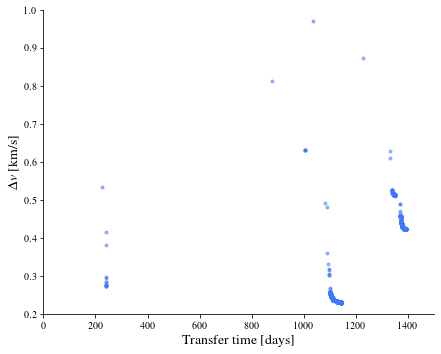

In [16]:
plt.plot(tt_data/86400., vel_data, linestyle='None', marker='.', color='xkcd:lightish blue', alpha=.5)
plt.ylim((.2, 1.0))
plt.xlim((0, 1500))


plt.xlabel('Transfer time [days]')
plt.ylabel('$\Delta v$ [km/s]')